Hybrid Forex prediction model using multiple regression, simulated annealing, reinforcement learning and technical analysis

https://www.researchgate.net/profile/Chihab-Younes/publication/366165718_Hybrid_Forex_prediction_model_using_multiple_regression_simulated_annealing_reinforcement_learning_and_technical_analysis/links/6393e9e0e42faa7e75aefbac/Hybrid-Forex-prediction-model-using-multiple-regression-simulated-annealing-reinforcement-learning-and-technical-analysis.pdf?origin=publication_detail

In [469]:
# Libraries and Modules used
import MetaTrader5 as mt5 
import pandas as pd
from sklearn.linear_model import LinearRegression
import ta
import warnings
warnings.filterwarnings("ignore")
import numpy as np
# warnings.filterwarnings("ignore")
mt5.initialize()
# Replace following with your MT5 Account Login
account=51127988 # 
password="Aar2frM7"
server = 'ICMarkets-Demo'

In [470]:
# Function to get rates from MT5 
def get_rates(pair1, timeframe, x):
    pair1 = pd.DataFrame(mt5.copy_rates_from_pos(pair1, timeframe, 0, x))
    pair1['time'] = pd.to_datetime(pair1['time'], unit = 's')
    return pair1

## Backtesting 

In [471]:
# Code to get X Variables 
EURUSD = get_rates('EURUSD.a', mt5.TIMEFRAME_D1, 1000)
EURUSD = EURUSD[['close']]
# Gets the last 6 closes of chosen timeframe. If you chose daily tf, it'll get last 6 days. If 4 hour, it'll get last
# 6 4 hour candles etc etc. 
for i in range(1,7):
    EURUSD[f'Period {i}'] = EURUSD['close'].shift(i)

# Gets 2 week and 1 month averages 
EURUSD['2w'] = EURUSD['close'].rolling(window = 14).mean()
EURUSD['1m'] = EURUSD['close'].rolling(window = 30).mean()

# Added an RSI as a variable 
EURUSD['rsi'] = ta.momentum.rsi(EURUSD['close'], window = 14, fillna = False)

EURUSD = EURUSD.dropna()

In [472]:
EU_x = EURUSD
EU_x = EU_x.drop('close', axis = 1)

In [473]:
# Defining X (features) and y (target)
X = EU_x
X = X.dropna()
y = EURUSD['close']

In [474]:
##Define the model
from sklearn.linear_model import LinearRegression
# Create and train the model (replace with your actual training code)
model = LinearRegression()
model.fit(X, y)

LinearRegression()

<AxesSubplot:>

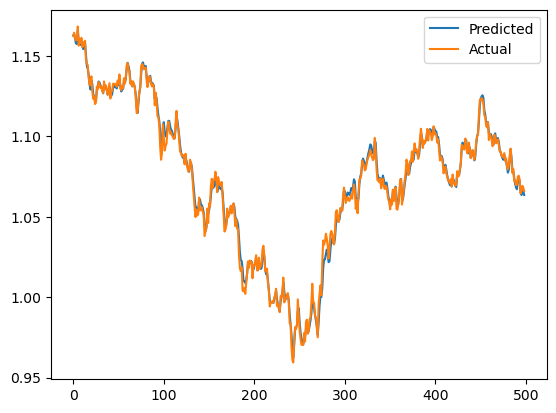

In [475]:
vals = pd.DataFrame()  # Create an empty DataFrame to put the following code into. 

for i in range(500, 1, -1):  
    # Train a new model using all data up to day (-i)
    X_train = X.iloc[:-i]
    y_train = y.iloc[:-i]
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict the close price for day (-i + 1)
    today_features = X.iloc[-i]
    today_price = model.predict([today_features])[0]
    
    vals = vals.append({'Predicted': today_price, 'Actual': y.iloc[-i]}, ignore_index=True)

vals.plot()

<AxesSubplot:>

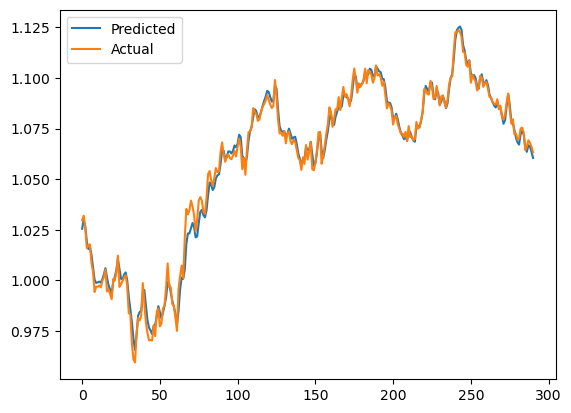

In [476]:
# Create an empty DataFrame to store the results.
vals = pd.DataFrame()

# Define the number of days in the testing data
num_test_days = int(0.3 * len(X))

for i in range(num_test_days, 0, -1):  
    # Train a new model using the first 70% of data up to day (-i)
    cutoff = -i - int(0.7 * i)
    X_train = X.iloc[:cutoff]
    y_train = y.iloc[:cutoff]
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict the close price for day (-i)
    today_features = X.iloc[-i]
    today_price = model.predict([today_features])[0]
    
    vals = vals.append({'Predicted': today_price, 'Actual': y.iloc[-i]}, ignore_index=True)

vals.plot()

In [477]:
vals['diff'] = (vals['Actual'] - vals['Predicted']) * 10000
vals['diff'].describe()

count    291.000000
mean      -1.023694
std       37.651354
min     -105.463542
25%      -21.655179
50%       -7.263401
75%       17.638861
max      173.744361
Name: diff, dtype: float64

In [478]:
vals[:-1]

,Predicted,Actual,diff
0,1.025470,1.02978,43.103209
1,1.030060,1.03197,19.103409
2,1.026761,1.02589,-8.711308
3,1.019312,1.01592,-33.920657
4,1.015477,1.01705,15.731954
...,...,...,...
285,1.065514,1.06443,-10.843721
286,1.063519,1.06611,25.907171
287,1.066750,1.06923,24.796137
288,1.066132,1.06793,17.979393


## Predicting 

In [479]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Code to get X Variables 
EURUSD = get_rates('AUDUSD.a', mt5.TIMEFRAME_D1, 1000)
EURUSD = EURUSD[['close']]

# Getting lags and rolling averages
for i in range(1,7):
    EURUSD[f'Period {i}'] = EURUSD['close'].shift(i)
    
EURUSD['2w'] = EURUSD['close'].rolling(window = 14).mean()
EURUSD['1m'] = EURUSD['close'].rolling(window = 30).mean()

# RSI
EURUSD['rsi'] = ta.momentum.rsi(EURUSD['close'], window = 14, fillna = False)

EURUSD = EURUSD.dropna()

# Drop the target variable 'close' to get predictors
X = EURUSD.drop('close', axis=1)

# Dropping most recent data (D) since we are predicting D with data from D-1, D-2 etc etc
X = X.iloc[:-1] 
y = EURUSD['close'].iloc[:-1] 

# Split data into training and test sets. Here, we reserve 30% for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Create and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Use the most recent features from the entire dataset to make a prediction for D+1 (Next Period)
next_close_prediction = model.predict([X.iloc[-1].values])

print(next_close_prediction[0])

0.6441856384832105


count    199.000000
mean       5.852280
std       38.507546
min      -93.756345
25%      -17.289222
50%        5.920438
75%       30.775919
max      124.549703
Name: Diff, dtype: float64


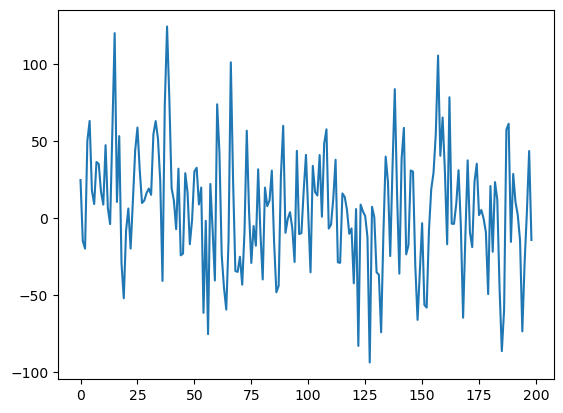

In [391]:
test_predictions = pd.DataFrame(columns=['Forward Predicted'])

for i in range(1, 200):
    n = i
    predicted_close = model.predict([X.iloc[-n-1].values])
    test_predictions.loc[i] = [predicted_close[0]]
    
test_predictions = test_predictions.iloc[::-1].reset_index(drop=True)

test_predictions['Historical Predictions'] = vals['Predicted'].iloc[91:-1].reset_index(drop=True)
test_predictions['Diff'] = (test_predictions['Forward Predicted'] - test_predictions['Historical Predictions']) * 10000
test_predictions['Diff'].plot()
print(test_predictions['Diff'].describe())

## Calculating Avg Ranges 

In [422]:
### Calculating Avg Ranges 
EURUSD['diff'] = EURUSD['close'].diff().abs()
EURUSD['diff'] = EURUSD['diff'] * 10000
avg = EURUSD['diff'].rolling(window = 14).mean()
### Change the number below to find the mean of the last x periods based on a rolling window of 14. Excludes most recent price. 
avg.iloc[-8:-1].mean()

25.38469387755108

In [ ]:
def m2():
    # Drop the target variable 'close' to get predictors
    X = EURUSD.drop('close', axis=1)

    # Dropping most recent data (D) since we are predicting D with data from D-1, D-2 etc etc
    X = X.iloc[:-1] 
    y = EURUSD['close'].iloc[:-1] 

    # Splitting data into 70% training and 30% testing
    train_size = int(0.7 * len(X))
    X_train = X.iloc[:train_size]
    y_train = y.iloc[:train_size]
    X_test = X.iloc[train_size:]
    y_test = y.iloc[train_size:]

    model = LinearRegression()
    model.fit(X_train, y_train)

    # Use the most recent features from the training set to make a prediction for D+1 (Next Period)
    next_close_prediction = model.predict([X_train.iloc[-1].values])

    print(next_close_prediction[0])

In [442]:
from sklearn.linear_model import LinearRegression

# Code to get X Variables 
EURUSD = get_rates('AUDUSD.a', mt5.TIMEFRAME_D1, 1000)
EURUSD = EURUSD[['close']]

# Getting lags and rolling averages
for i in range(1,7):
    EURUSD[f'Period {i}'] = EURUSD['close'].shift(i)
    
EURUSD['2w'] = EURUSD['close'].rolling(window = 14).mean()
EURUSD['1m'] = EURUSD['close'].rolling(window = 30).mean()

# RSI
EURUSD['rsi'] = ta.momentum.rsi(EURUSD['close'], window = 14, fillna = False)

EURUSD = EURUSD.dropna()

# Drop the target variable 'close' to get predictors
X = EURUSD.drop('close', axis=1)
y = EURUSD['close']


<AxesSubplot:>

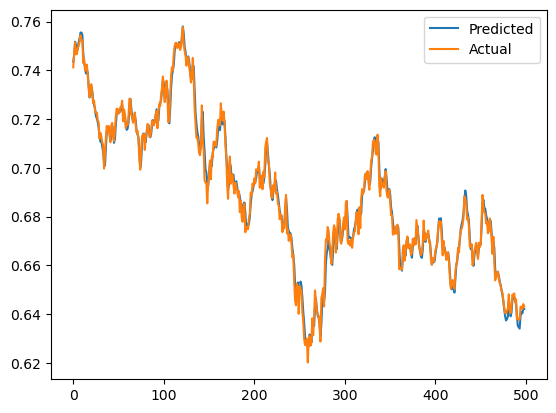

In [445]:
vals = pd.DataFrame()  # Create an empty DataFrame

for i in range(500, 1, -1):  
    # Train a new model using all data up to day (-i)
    X_train = X.iloc[:-i]
    y_train = y.iloc[:-i]
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict the close price for day (-i + 1)
    today_features = X.iloc[-i]
    today_price = model.predict([today_features])[0]
    
    vals = vals.append({'Predicted': today_price, 'Actual': y.iloc[-i]}, ignore_index=True)

vals.plot()

In [446]:
# Train model on entire dataset except the last data point
model_full = LinearRegression()
model_full.fit(X.iloc[:-1], y.iloc[:-1])

# Predict for the next day
next_close_prediction = model_full.predict([X.iloc[-1].values])
print(next_close_prediction[0])


0.6416618338485868


In [449]:
from sklearn.linear_model import LinearRegression

def model_price(X, y, mode="backtest", days=1):
    results = {}
    
    if mode == "backtest":
        vals = pd.DataFrame()  # Create an empty DataFrame

        for i in range(days, 1, -1):  
            # Train a new model using all data up to day (-i)
            X_train = X.iloc[:-i]
            y_train = y.iloc[:-i]
            model = LinearRegression()
            model.fit(X_train, y_train)

            # Predict the close price for day (-i + 1)
            today_features = X.iloc[-i]
            today_price = model.predict([today_features])[0]

            vals = vals.append({'Predicted': today_price, 'Actual': y.iloc[-i]}, ignore_index=True)

        results = vals
    
    elif mode == "forecast":
        model_full = LinearRegression()
        model_full.fit(X.iloc[:-days], y.iloc[:-days])

        # Forecast prices for the number of days specified
        forecasted_prices = []
        for i in range(days):
            next_close_prediction = model_full.predict([X.iloc[-(days-i)].values])[0]
            forecasted_prices.append(next_close_prediction)
        
        results = {"Forecasted Prices": forecasted_prices}
    
    return results

# Define your data
EURUSD = get_rates('AUDUSD.a', mt5.TIMEFRAME_D1, 1000)
EURUSD = EURUSD[['close']]

# ... Your data processing code (e.g., RSI, lag features, etc.) ...
# Getting lags and rolling averages
for i in range(1,7):
    EURUSD[f'Period {i}'] = EURUSD['close'].shift(i)
    
EURUSD['2w'] = EURUSD['close'].rolling(window = 14).mean()
EURUSD['1m'] = EURUSD['close'].rolling(window = 30).mean()

# RSI
EURUSD['rsi'] = ta.momentum.rsi(EURUSD['close'], window = 14, fillna = False)

EURUSD = EURUSD.dropna()

X = EURUSD.drop('close', axis=1)
y = EURUSD['close']

# Use the function for backtesting for the last 500 days
backtest_results = model_price(X, y, mode="backtest", days=500)
print(backtest_results)

# Use the function to forecast the price for the next 5 days
forecast_results = model_price(X, y, mode="forecast", days=1)
print(forecast_results)


     Predicted   Actual
0     0.743515  0.74120
1     0.746106  0.74720
2     0.751749  0.75147
3     0.750542  0.74667
4     0.747723  0.74665
..         ...      ...
494   0.639157  0.64303
495   0.640893  0.64262
496   0.640267  0.64209
497   0.642161  0.64405
498   0.642149  0.64310

[499 rows x 2 columns]
{'Forecasted Prices': [0.6415682436068508]}
